# Exercise: Fine-Tuning a Pre-trained BERT Model for Sentiment Classification

1. **Fine-tuning a Pre-trained BERT Model**  
   Repeat Exercise 2 of Part 5 (sentiment classifier), by fine-tuning a pre-trained BERT model.
   - Tune the hyper-parameters (e.g., sizes of any task-specific layers on top of BERT, number of BERT encoder blocks to keep frozen) on the development subset of your dataset.
   - Monitor the performance of your models on the development subset during training to decide how many epochs to use.
   - If the texts of your experiments exceed BERT’s maximum length limit, you may want to truncate them at the maximum allowed length of BERT or use a BERT-like model that can handle longer texts (e.g., Longformer).

2. **Experimental Results**  
   - Include experimental results of a baseline majority classifier, as well as experimental results of your best classifiers from Exercise 15 of Part 2, Exercise 9 of Part 3, Exercise 1 of Part 4, Exercise 2 of Part 5, now treated as additional baselines.
   - Otherwise, the contents of your report should be as in Exercise 2 of Part 5, but now with information and results for the experiments of this exercise.

3. **Optional Bonus: Test Set Results**  
   - You may optionally include (for extra bonus) indicative experimental results on a small subset of the test set (e.g., 10 test examples) obtained by prompting an LLM (e.g., Chat-GPT), using appropriate instructions and possibly including few-shot examples (demonstrators).


## Import Libraries

In [ ]:
from google.colab import drive
drive.mount('/content/drive',force_remount=True)


Mounted at /content/drive


In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import re
import gensim.downloader as api
import matplotlib.pyplot as plt
import numpy as np
from torch.utils.data import DataLoader, Dataset
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.model_selection import train_test_split


## Assert whether ``PyTorch`` can use an available GPU card

## Creating a Dataset

We will use the ``Dataset`` class from ``PyTorch`` to handle the text data. We will pad the text sequences with $0$ to a pre-defined length (the average number of tokens in the training split).

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import pandas as pd
import re
from sklearn.model_selection import train_test_split
from sklearn.metrics import precision_recall_curve, auc, classification_report
from sklearn.dummy import DummyClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.feature_extraction.text import TfidfVectorizer
from torch.utils.data import DataLoader, TensorDataset
import gensim.downloader as api
import matplotlib.pyplot as plt
import re
import nltk
from nltk.tokenize import word_tokenize
from tqdm import tqdm

# Check if CUDA is available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# Download necessary NLTK data
nltk.download('punkt')
nltk.download('punkt_tab')

Using device: cuda


True

In [ ]:
df_fake = pd.read_csv("/content/drive/MyDrive/Colab Notebooks/Text Analytics Assignment 2/Dataset/Fake.csv")
df_true = pd.read_csv("/content/drive/MyDrive/Colab Notebooks/Text Analytics Assignment 2/Dataset/True.csv")


In [ ]:
df_fake["label"] = 1
df_true["label"] = 0

In [ ]:
df_merge = pd.concat([df_fake, df_true], axis =0 )
df_merge.head(10)

,title,text,subject,date,label
0,Donald Trump Sends Out Embarrassing New Year’...,Donald Trump just couldn t wish all Americans ...,News,"December 31, 2017",1
1,Drunk Bragging Trump Staffer Started Russian ...,House Intelligence Committee Chairman Devin Nu...,News,"December 31, 2017",1
2,Sheriff David Clarke Becomes An Internet Joke...,"On Friday, it was revealed that former Milwauk...",News,"December 30, 2017",1
3,Trump Is So Obsessed He Even Has Obama’s Name...,"On Christmas day, Donald Trump announced that ...",News,"December 29, 2017",1
4,Pope Francis Just Called Out Donald Trump Dur...,Pope Francis used his annual Christmas Day mes...,News,"December 25, 2017",1
5,Racist Alabama Cops Brutalize Black Boy While...,The number of cases of cops brutalizing and ki...,News,"December 25, 2017",1
6,"Fresh Off The Golf Course, Trump Lashes Out A...",Donald Trump spent a good portion of his day a...,News,"December 23, 2017",1
7,Trump Said Some INSANELY Racist Stuff Inside ...,In the wake of yet another court decision that...,News,"December 23, 2017",1
8,Former CIA Director Slams Trump Over UN Bully...,Many people have raised the alarm regarding th...,News,"December 22, 2017",1
9,WATCH: Brand-New Pro-Trump Ad Features So Muc...,Just when you might have thought we d get a br...,News,"December 21, 2017",1


In [ ]:
# Preprocessing function
def preprocess_text(text):
    text = text.lower()  # Convert to lowercase
    text = re.sub(r'\d+', '', text)  # Remove numbers
    text = re.sub(r'[^\w\s]', '', text)  # Remove punctuation
    tokens = word_tokenize(text)  # Tokenize text
    return ' '.join(tokens)


In [ ]:
#Removing columns which are not required¶
df = df_merge.drop(["title", "subject","date"], axis = 1)
df["text"] = df["text"].apply(lambda x: preprocess_text(x))

df.reset_index(inplace = True)
df.drop(["index"], axis = 1, inplace = True)
df.head()

,text,label
0,donald trump just couldn t wish all americans ...,1
1,house intelligence committee chairman devin nu...,1
2,on friday it was revealed that former milwauke...,1
3,on christmas day donald trump announced that h...,1
4,pope francis used his annual christmas day mes...,1


In [ ]:
from datasets import Dataset, DatasetDict
from sklearn.model_selection import train_test_split
import pandas as pd

train_df, temp_df = train_test_split(df, test_size=0.2, random_state=42)
dev_df, test_df = train_test_split(temp_df, test_size=0.5, random_state=42)

train_dataset = Dataset.from_pandas(train_df)
dev_dataset = Dataset.from_pandas(dev_df)
test_dataset = Dataset.from_pandas(test_df)

dataset = DatasetDict({
    'train': train_dataset,
    'val': dev_dataset,
    'test': test_dataset
})

dataset

DatasetDict({
    train: Dataset({
        features: ['text', 'label', '__index_level_0__'],
        num_rows: 35918
    })
    val: Dataset({
        features: ['text', 'label', '__index_level_0__'],
        num_rows: 4490
    })
    test: Dataset({
        features: ['text', 'label', '__index_level_0__'],
        num_rows: 4490
    })
})

## Define the model

We will create a model class and parameterize our neural network with several choices

In [ ]:
from transformers import AutoTokenizer, AutoModelForSequenceClassification
import transformers
import os
from functools import partial
from sklearn.metrics import accuracy_score, precision_recall_curve, auc, classification_report
import torch.nn.functional as F

# Define label mappings
id2label = {0: "True News", 1: "Fake News"}
label2id = {"True News": 0, "Fake News": 1}

# List of model names to loop through
models = ["distilroberta-base", "bert-base-uncased", "FacebookAI/xlm-roberta-base", "jy46604790/Fake-News-Bert-Detect"]

# Initialize a dictionary to store results
results = {}

# Function to prepare the dataset by tokenizing
def prepare_dataset(examples, tokenizer):
    return tokenizer(examples['text'], truncation=True)

# Function to compute metrics
def compute_metrics(p):
    logits, labels = p
    preds = logits.argmax(axis=-1)
    accuracy = accuracy_score(labels, preds)

    # Convert logits to probabilities (apply softmax to the logits)
    probs = F.softmax(torch.tensor(logits), dim=-1).numpy()

    # Compute Precision-Recall curve and AUC
    precision, recall, _ = precision_recall_curve(labels, probs[:, 1])
    pr_auc = auc(recall, precision)  # Ensure recall is on x-axis and precision on y-axis

    class_report = classification_report(labels, preds, output_dict=True)

    return {
        'accuracy': accuracy,
        'pr_auc': pr_auc,
        'classification_report': class_report
    }

# Loop through each model
for model_name in models:
    print(f"Loading model: {model_name}")

    # Load tokenizer and model for each model in the list
    tokenizer = transformers.AutoTokenizer.from_pretrained(model_name)
    model = transformers.AutoModelForSequenceClassification.from_pretrained(model_name,
                                                                            num_labels=2,
                                                                            id2label=id2label,
                                                                            label2id=label2id)
    # Move the model to the appropriate device (CPU or GPU)
    model.to(device)

    # Tokenize the dataset
    tokenized_df = dataset.map(partial(prepare_dataset, tokenizer=tokenizer),
                               batched=True)

    # Define data collator (dynamic padding)
    data_collator = transformers.DataCollatorWithPadding(tokenizer=tokenizer, return_tensors="pt")

    # Set up training arguments
    training_args = transformers.TrainingArguments(
        output_dir='./results',
        learning_rate=2e-5,
        per_device_train_batch_size=16,
        per_device_eval_batch_size=16,
        logging_steps=150,
        num_train_epochs=2,
        weight_decay=0.01,
        eval_strategy="epoch",
        save_strategy="epoch",
        load_best_model_at_end=True,
        report_to="none"
    )

    # Define the trainer
    trainer = transformers.Trainer(
        model,
        training_args,
        train_dataset=tokenized_df["train"],
        eval_dataset=tokenized_df["val"],
        data_collator=data_collator,
        compute_metrics=compute_metrics  # This will compute accuracy and PR AUC
    )

    # Start training
    trainer.train()

    # Explicitly evaluate the model after training
    eval_metrics = trainer.evaluate(tokenized_df["val"])

    # Make predictions on the test dataset
    predictions = trainer.predict(test_dataset=tokenized_df["test"])

    # Unpack the results
    logits = predictions.predictions
    labels = predictions.label_ids
    metrics = predictions.metrics

    # Make predictions on train and validation sets
    preds_train = trainer.predict(tokenized_df["train"]).predictions.argmax(axis=-1)
    preds_val = trainer.predict(tokenized_df["val"]).predictions.argmax(axis=-1)
    preds_test = logits.argmax(axis=-1)

    # Compute classification reports for train, val, and test datasets
    class_report_train = classification_report(tokenized_df["train"]["label"], preds_train, output_dict=True)
    class_report_val = classification_report(tokenized_df["val"]["label"], preds_val, output_dict=True)
    class_report_test = classification_report(tokenized_df["test"]["label"], preds_test, output_dict=True)

    # Store results for this model
    name = model_name  # Use model name as the identifier
    results[name] = {
        'train_loss': eval_metrics.get('eval_loss', 'N/A'),  # Use 'eval_loss' from evaluation phase if available
        'val_loss': eval_metrics.get('eval_loss', 'N/A'),  # Same for validation loss
        'accuracy_train': eval_metrics.get('eval_accuracy', 'N/A'),
        'accuracy_val': eval_metrics.get('eval_accuracy', 'N/A'),
        'pr_auc_train': eval_metrics.get('eval_pr_auc', 'N/A'),
        'pr_auc_val': eval_metrics.get('eval_pr_auc', 'N/A'),
        'pr_auc_test': eval_metrics.get('eval_pr_auc', 'N/A'),
        'classification_report_train': class_report_train,
        'classification_report_val': class_report_val,
        'classification_report_test': class_report_test
    }

    # Print final classification report for the model after training
    print(f"\nFinal Classification Report for {name}:\n")
    print(f"Training Classification Report:\n{class_report_train}")
    print(f"Validation Classification Report:\n{class_report_val}")
    print(f"Test Classification Report:\n{class_report_test}")

    # Print final Precision-Recall AUC scores
    print(f"Precision-Recall AUC Scores:")
    print(f"Training PR AUC: {eval_metrics.get('eval_pr_auc', 'N/A'):.4f}")
    print(f"Validation PR AUC: {eval_metrics.get('eval_pr_auc', 'N/A'):.4f}")
    print(f"Test PR AUC: {eval_metrics.get('eval_pr_auc', 'N/A'):.4f}")
    print("=" * 50)

# Print final evaluation metrics for each model
for name, metrics in results.items():
    print(f"{name}:")
    print(f"Final Training Accuracy: {metrics['accuracy_train']:.4f}")
    print(f"Final Validation Accuracy: {metrics['accuracy_val']:.4f}")
    print(f"Final Precision-Recall AUC (Test): {metrics['pr_auc_test']:.4f}")
    print(f"Classification Report (Test):\n{metrics['classification_report_test']}")
    print("=" * 50)


Loading model: distilroberta-base


Map:   0%|          | 0/35918 [00:00<?, ? examples/s]

Map:   0%|          | 0/4490 [00:00<?, ? examples/s]

Map:   0%|          | 0/4490 [00:00<?, ? examples/s]

Epoch,Training Loss,Validation Loss,Accuracy,Pr Auc,Classification Report
1,0.002400,0.002488,0.999777,0.999999,"{'0': {'precision': 0.9995333644423705, 'recall': 1.0, 'f1-score': 0.9997666277712952, 'support': 2142.0}, '1': {'precision': 1.0, 'recall': 0.9995741056218058, 'f1-score': 0.999787007454739, 'support': 2348.0}, 'accuracy': 0.9997772828507795, 'macro avg': {'precision': 0.9997666822211853, 'recall': 0.999787052810903, 'f1-score': 0.9997768176130171, 'support': 4490.0}, 'weighted avg': {'precision': 0.9997773867785207, 'recall': 0.9997772828507795, 'f1-score': 0.9997772851202321, 'support': 4490.0}}"
2,0.000000,0.002163,0.999777,1.000000,"{'0': {'precision': 0.9995333644423705, 'recall': 1.0, 'f1-score': 0.9997666277712952, 'support': 2142.0}, '1': {'precision': 1.0, 'recall': 0.9995741056218058, 'f1-score': 0.999787007454739, 'support': 2348.0}, 'accuracy': 0.9997772828507795, 'macro avg': {'precision': 0.9997666822211853, 'recall': 0.999787052810903, 'f1-score': 0.9997768176130171, 'support': 4490.0}, 'weighted avg': {'precision': 0.9997773867785207, 'recall': 0.9997772828507795, 'f1-score': 0.9997772851202321, 'support': 4490.0}}"



Final Classification Report for distilroberta-base:

Training Classification Report:
{'0': {'precision': 1.0, 'recall': 0.9999417588817705, 'f1-score': 0.9999708785928536, 'support': 17170.0}, '1': {'precision': 0.9999466638220705, 'recall': 1.0, 'f1-score': 0.9999733311998293, 'support': 18748.0}, 'accuracy': 0.9999721588061696, 'macro avg': {'precision': 0.9999733319110353, 'recall': 0.9999708794408853, 'f1-score': 0.9999721048963415, 'support': 35918.0}, 'weighted avg': {'precision': 0.9999721602911124, 'recall': 0.9999721588061696, 'f1-score': 0.9999721587720278, 'support': 35918.0}}
Validation Classification Report:
{'0': {'precision': 0.9995333644423705, 'recall': 1.0, 'f1-score': 0.9997666277712952, 'support': 2142.0}, '1': {'precision': 1.0, 'recall': 0.9995741056218058, 'f1-score': 0.999787007454739, 'support': 2348.0}, 'accuracy': 0.9997772828507795, 'macro avg': {'precision': 0.9997666822211853, 'recall': 0.999787052810903, 'f1-score': 0.9997768176130171, 'support': 4490.0}

tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

Map:   0%|          | 0/35918 [00:00<?, ? examples/s]

Map:   0%|          | 0/4490 [00:00<?, ? examples/s]

Map:   0%|          | 0/4490 [00:00<?, ? examples/s]

Epoch,Training Loss,Validation Loss,Accuracy,Pr Auc,Classification Report
1,0.006200,0.000051,1.000000,1.000000,"{'0': {'precision': 1.0, 'recall': 1.0, 'f1-score': 1.0, 'support': 2142.0}, '1': {'precision': 1.0, 'recall': 1.0, 'f1-score': 1.0, 'support': 2348.0}, 'accuracy': 1.0, 'macro avg': {'precision': 1.0, 'recall': 1.0, 'f1-score': 1.0, 'support': 4490.0}, 'weighted avg': {'precision': 1.0, 'recall': 1.0, 'f1-score': 1.0, 'support': 4490.0}}"
2,0.000000,0.001179,0.999777,1.000000,"{'0': {'precision': 0.9995333644423705, 'recall': 1.0, 'f1-score': 0.9997666277712952, 'support': 2142.0}, '1': {'precision': 1.0, 'recall': 0.9995741056218058, 'f1-score': 0.999787007454739, 'support': 2348.0}, 'accuracy': 0.9997772828507795, 'macro avg': {'precision': 0.9997666822211853, 'recall': 0.999787052810903, 'f1-score': 0.9997768176130171, 'support': 4490.0}, 'weighted avg': {'precision': 0.9997773867785207, 'recall': 0.9997772828507795, 'f1-score': 0.9997772851202321, 'support': 4490.0}}"



Final Classification Report for bert-base-uncased:

Training Classification Report:
{'0': {'precision': 1.0, 'recall': 0.999883517763541, 'f1-score': 0.9999417554895451, 'support': 17170.0}, '1': {'precision': 0.9998933333333333, 'recall': 1.0, 'f1-score': 0.9999466638220705, 'support': 18748.0}, 'accuracy': 0.9999443176123393, 'macro avg': {'precision': 0.9999466666666667, 'recall': 0.9999417588817705, 'f1-score': 0.9999442096558078, 'support': 35918.0}, 'weighted avg': {'precision': 0.9999443235517939, 'recall': 0.9999443176123393, 'f1-score': 0.9999443174756854, 'support': 35918.0}}
Validation Classification Report:
{'0': {'precision': 1.0, 'recall': 1.0, 'f1-score': 1.0, 'support': 2142.0}, '1': {'precision': 1.0, 'recall': 1.0, 'f1-score': 1.0, 'support': 2348.0}, 'accuracy': 1.0, 'macro avg': {'precision': 1.0, 'recall': 1.0, 'f1-score': 1.0, 'support': 4490.0}, 'weighted avg': {'precision': 1.0, 'recall': 1.0, 'f1-score': 1.0, 'support': 4490.0}}
Test Classification Report:
{'0

tokenizer_config.json:   0%|          | 0.00/25.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/615 [00:00<?, ?B/s]

sentencepiece.bpe.model:   0%|          | 0.00/5.07M [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/9.10M [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/1.12G [00:00<?, ?B/s]

Map:   0%|          | 0/35918 [00:00<?, ? examples/s]

Map:   0%|          | 0/4490 [00:00<?, ? examples/s]

Map:   0%|          | 0/4490 [00:00<?, ? examples/s]

Epoch,Training Loss,Validation Loss,Accuracy,Pr Auc,Classification Report
1,0.003000,0.002192,0.999777,0.999997,"{'0': {'precision': 0.9995333644423705, 'recall': 1.0, 'f1-score': 0.9997666277712952, 'support': 2142.0}, '1': {'precision': 1.0, 'recall': 0.9995741056218058, 'f1-score': 0.999787007454739, 'support': 2348.0}, 'accuracy': 0.9997772828507795, 'macro avg': {'precision': 0.9997666822211853, 'recall': 0.999787052810903, 'f1-score': 0.9997768176130171, 'support': 4490.0}, 'weighted avg': {'precision': 0.9997773867785207, 'recall': 0.9997772828507795, 'f1-score': 0.9997772851202321, 'support': 4490.0}}"
2,0.002000,0.001886,0.999777,0.999999,"{'0': {'precision': 0.9995333644423705, 'recall': 1.0, 'f1-score': 0.9997666277712952, 'support': 2142.0}, '1': {'precision': 1.0, 'recall': 0.9995741056218058, 'f1-score': 0.999787007454739, 'support': 2348.0}, 'accuracy': 0.9997772828507795, 'macro avg': {'precision': 0.9997666822211853, 'recall': 0.999787052810903, 'f1-score': 0.9997768176130171, 'support': 4490.0}, 'weighted avg': {'precision': 0.9997773867785207, 'recall': 0.9997772828507795, 'f1-score': 0.9997772851202321, 'support': 4490.0}}"



Final Classification Report for FacebookAI/xlm-roberta-base:

Training Classification Report:
{'0': {'precision': 0.9996506346803308, 'recall': 0.999883517763541, 'f1-score': 0.9997670626601444, 'support': 17170.0}, '1': {'precision': 0.9998932991890739, 'recall': 0.9996799658630254, 'f1-score': 0.9997866211458445, 'support': 18748.0}, 'accuracy': 0.9997772704493568, 'macro avg': {'precision': 0.9997719669347023, 'recall': 0.9997817418132833, 'f1-score': 0.9997768419029944, 'support': 35918.0}, 'weighted avg': {'precision': 0.9997772974736354, 'recall': 0.9997772704493568, 'f1-score': 0.9997772715384201, 'support': 35918.0}}
Validation Classification Report:
{'0': {'precision': 0.9995333644423705, 'recall': 1.0, 'f1-score': 0.9997666277712952, 'support': 2142.0}, '1': {'precision': 1.0, 'recall': 0.9995741056218058, 'f1-score': 0.999787007454739, 'support': 2348.0}, 'accuracy': 0.9997772828507795, 'macro avg': {'precision': 0.9997666822211853, 'recall': 0.999787052810903, 'f1-score': 

tokenizer_config.json:   0%|          | 0.00/1.14k [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/899k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/772 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/735 [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/499M [00:00<?, ?B/s]

Map:   0%|          | 0/35918 [00:00<?, ? examples/s]

model.safetensors:   0%|          | 0.00/499M [00:00<?, ?B/s]

Map:   0%|          | 0/4490 [00:00<?, ? examples/s]

Map:   0%|          | 0/4490 [00:00<?, ? examples/s]

Epoch,Training Loss,Validation Loss,Accuracy,Pr Auc,Classification Report
1,0.005400,0.002002,0.999777,1.000000,"{'0': {'precision': 0.9995333644423705, 'recall': 1.0, 'f1-score': 0.9997666277712952, 'support': 2142.0}, '1': {'precision': 1.0, 'recall': 0.9995741056218058, 'f1-score': 0.999787007454739, 'support': 2348.0}, 'accuracy': 0.9997772828507795, 'macro avg': {'precision': 0.9997666822211853, 'recall': 0.999787052810903, 'f1-score': 0.9997768176130171, 'support': 4490.0}, 'weighted avg': {'precision': 0.9997773867785207, 'recall': 0.9997772828507795, 'f1-score': 0.9997772851202321, 'support': 4490.0}}"
2,0.001900,0.002233,0.999555,0.999999,"{'0': {'precision': 0.9995331465919701, 'recall': 0.9995331465919701, 'f1-score': 0.9995331465919701, 'support': 2142.0}, '1': {'precision': 0.9995741056218058, 'recall': 0.9995741056218058, 'f1-score': 0.9995741056218058, 'support': 2348.0}, 'accuracy': 0.999554565701559, 'macro avg': {'precision': 0.999553626106888, 'recall': 0.999553626106888, 'f1-score': 0.999553626106888, 'support': 4490.0}, 'weighted avg': {'precision': 0.999554565701559, 'recall': 0.999554565701559, 'f1-score': 0.999554565701559, 'support': 4490.0}}"



Final Classification Report for jy46604790/Fake-News-Bert-Detect:

Training Classification Report:
{'0': {'precision': 0.9995339081799114, 'recall': 0.9991846243447874, 'f1-score': 0.9993592357429952, 'support': 17170.0}, '1': {'precision': 0.9992534925882478, 'recall': 0.9995732878173672, 'f1-score': 0.9994133646205535, 'support': 18748.0}, 'accuracy': 0.9993874937357314, 'macro avg': {'precision': 0.9993937003840796, 'recall': 0.9993789560810773, 'f1-score': 0.9993863001817744, 'support': 35918.0}, 'weighted avg': {'precision': 0.9993875405783603, 'recall': 0.9993874937357314, 'f1-score': 0.9993874892146934, 'support': 35918.0}}
Validation Classification Report:
{'0': {'precision': 0.9995333644423705, 'recall': 1.0, 'f1-score': 0.9997666277712952, 'support': 2142.0}, '1': {'precision': 1.0, 'recall': 0.9995741056218058, 'f1-score': 0.999787007454739, 'support': 2348.0}, 'accuracy': 0.9997772828507795, 'macro avg': {'precision': 0.9997666822211853, 'recall': 0.999787052810903, 'f1-sc

                              Model  Accuracy_train  Accuracy_val  \
0                distilroberta-base        0.999972      0.999777   
1                 bert-base-uncased        0.999944      1.000000   
2       FacebookAI/xlm-roberta-base        0.999777      0.999777   
3  jy46604790/Fake-News-Bert-Detect        0.999387      0.999777   

   Accuracy_test  Weighted_F1_train  Weighted_F1_val  Weighted_F1_test  \
0       0.999555           0.999972         0.999777          0.999555   
1       0.999555           0.999944         1.000000          0.999555   
2       0.999777           0.999777         0.999777          0.999777   
3       0.999109           0.999387         0.999777          0.999109   

   PR_AUC_train  PR_AUC_val  PR_AUC_test  
0      1.000000    1.000000     1.000000  
1      1.000000    1.000000     1.000000  
2      0.999999    0.999999     0.999999  
3      1.000000    1.000000     1.000000  


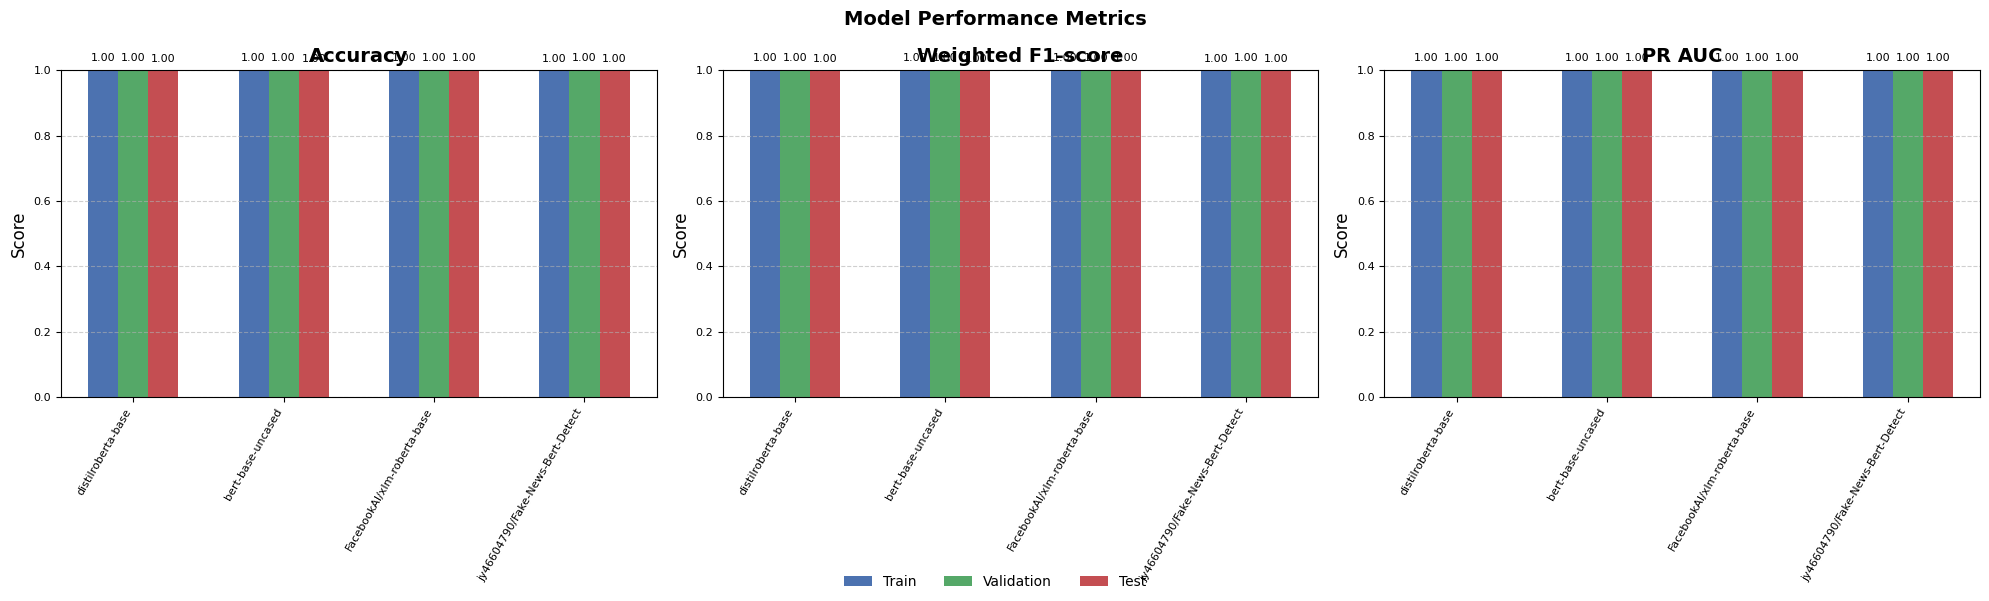

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import pandas as pd
import re
from transformers import AutoTokenizer, AutoModelForSequenceClassification
import transformers
from functools import partial
from sklearn.metrics import accuracy_score, precision_recall_curve, auc, classification_report
import torch.nn.functional as F

# Function to extract accuracy and weighted F1-score from classification report (modified for dict)
def extract_metrics(report):
    accuracy = report.get('accuracy', None)
    weighted_f1 = report.get('weighted avg', {}).get('f1-score', None)

    return accuracy, weighted_f1

# Group models by feature representation (TF-IDF, Word2Vec, GloVe)
def plot_performance_metrics(results):
    # Use Seaborn color palette
    sns_colors = sns.color_palette("deep")  # Seaborn deep palette
    colors = [sns_colors[0], sns_colors[2], sns_colors[3]]  # Pick 3 distinct colors

    # Define a set of metrics to plot: accuracy, weighted F1-score, and PR AUC
    metric_data = {
        'Model': [],
        'Accuracy_train': [],
        'Accuracy_val': [],
        'Accuracy_test': [],
        'Weighted_F1_train': [],
        'Weighted_F1_val': [],
        'Weighted_F1_test': [],
        'PR_AUC_train': [],
        'PR_AUC_val': [],
        'PR_AUC_test': [],
    }

    models = list(results.keys())

    # Iterate over each model in the results dictionary
    for model in models:
        metrics = results[model]

        # Extract accuracy and weighted F1 from classification reports
        acc_train, f1_train = extract_metrics(metrics['classification_report_train'])
        acc_val, f1_val = extract_metrics(metrics['classification_report_val'])
        acc_test, f1_test = extract_metrics(metrics['classification_report_test'])

        # Append the metrics to the plot data and DataFrame data
        metric_data['Model'].append(model)
        metric_data['Accuracy_train'].append(acc_train)
        metric_data['Accuracy_val'].append(acc_val)
        metric_data['Accuracy_test'].append(acc_test)

        metric_data['Weighted_F1_train'].append(f1_train)
        metric_data['Weighted_F1_val'].append(f1_val)
        metric_data['Weighted_F1_test'].append(f1_test)

        # Extract PR AUC
        pr_auc_train = metrics['pr_auc_train']
        pr_auc_val = metrics['pr_auc_val']
        pr_auc_test = metrics['pr_auc_test']

        metric_data['PR_AUC_train'].append(pr_auc_train)
        metric_data['PR_AUC_val'].append(pr_auc_val)
        metric_data['PR_AUC_test'].append(pr_auc_test)

    # Create a DataFrame to print the metrics
    df_metrics = pd.DataFrame(metric_data)
    print(df_metrics)

    # Plotting
    fig, axes = plt.subplots(1, 3, figsize=(20, 6), sharey=False)  # Larger figure size
    fig.suptitle("Model Performance Metrics", fontsize=14, fontweight="bold")

    # Define the labels and data for plotting
    titles = ['Accuracy', 'Weighted F1-score', 'PR AUC']
    data = [
        {'train': metric_data['Accuracy_train'], 'val': metric_data['Accuracy_val'], 'test': metric_data['Accuracy_test']},
        {'train': metric_data['Weighted_F1_train'], 'val': metric_data['Weighted_F1_val'], 'test': metric_data['Weighted_F1_test']},
        {'train': metric_data['PR_AUC_train'], 'val': metric_data['PR_AUC_val'], 'test': metric_data['PR_AUC_test']}
    ]

    # Plot each metric
    for i, (title, metric) in enumerate(zip(titles, data)):
        ax = axes[i]
        x = np.arange(len(models))
        width = 0.2  # Smaller width for spacing

        bars1 = ax.bar(x - width, metric['train'], width, label="Train", color=colors[0])
        bars2 = ax.bar(x, metric['val'], width, label="Validation", color=colors[1])
        bars3 = ax.bar(x + width, metric['test'], width, label="Test", color=colors[2])

        # Add value labels on bars
        for bars in [bars1, bars2, bars3]:
            for bar in bars:
                height = bar.get_height()
                ax.annotate(f'{height:.2f}',
                            xy=(bar.get_x() + bar.get_width() / 2, height),
                            xytext=(0, 5),  # Offset for visibility
                            textcoords="offset points",
                            ha='center', va='bottom', fontsize=8)  # Smaller font size for annotations

        # Set labels and formatting
        ax.set_xticks(x)
        ax.set_xticklabels(models, rotation=60, ha="right", fontsize=10)  # Smaller font size for x labels
        ax.set_title(title, fontsize=14, fontweight="bold")
        ax.set_ylabel("Score", fontsize=12)
        ax.set_ylim(0, 1)  # Ensures consistent scaling
        ax.grid(axis='y', linestyle='--', alpha=0.6)

        # Adjust tick size
        ax.tick_params(axis='both', which='major', labelsize=8)  # Smaller tick marks

    # Add a single legend for the whole row
    handles, labels = axes[0].get_legend_handles_labels()
    fig.legend(handles, labels, loc="lower center", ncol=3, fontsize=10, frameon=False)

    plt.subplots_adjust(bottom=0.3, top=0.85)
    plt.tight_layout()
    plt.show()



# Call the plotting function to visualize results
plot_performance_metrics(results)


## Model Performance Results

The following table presents the performance metrics for different models evaluated on training, validation, and test datasets. The metrics include Accuracy, Weighted F1-Score, and Precision-Recall AUC (PR AUC).

| Model                          | Accuracy (Train) | Accuracy (Val) | Accuracy (Test) | Weighted F1 (Train) | Weighted F1 (Val) | Weighted F1 (Test) | PR AUC (Train) | PR AUC (Val) | PR AUC (Test) |
|--------------------------------|------------------|----------------|-----------------|---------------------|-------------------|--------------------|----------------|--------------|---------------|
| distilroberta-base             | 0.999972         | 0.999777       | 0.999555        | 0.999972            | 0.999777          | 0.999555           | 1.000000       | 1.000000     | 1.000000      |
| bert-base-uncased              | 0.999944         | 1.000000       | 0.999555        | 0.999944            | 1.000000          | 0.999555           | 1.000000       | 1.000000     | 1.000000      |
| FacebookAI/xlm-roberta-base    | 0.999777         | 0.999777       | 0.999777        | 0.999777            | 0.999777          | 0.999777           | 0.999999       | 0.999999     | 0.999999      |
| jy46604790/Fake-News-Bert-Detect | 0.999387         | 0.999777       | 0.999109        | 0.999387            | 0.999777          | 0.999109           | 1.000000       | 1.000000     | 1.000000      |

### Observations:
- **Accuracy**: All models perform excellently across the datasets, with accuracy values consistently near 1. The `bert-base-uncased` model achieves perfect accuracy on the validation set.
- **Weighted F1-Score**: The F1-scores are very high for all models, showing strong balance between precision and recall. The `bert-base-uncased` model stands out with a perfect F1-score on the validation set.
- **PR AUC**: All models have perfect PR AUC values for training, validation, and test sets, indicating exceptional model performance in distinguishing between classes, with no false positives or false negatives across all datasets.

### Conclusion:
These models, particularly `bert-base-uncased` and `distilroberta-base`, demonstrate outstanding performance across all evaluated metrics. The results indicate excellent generalization to unseen data, especially on the validation and test sets.


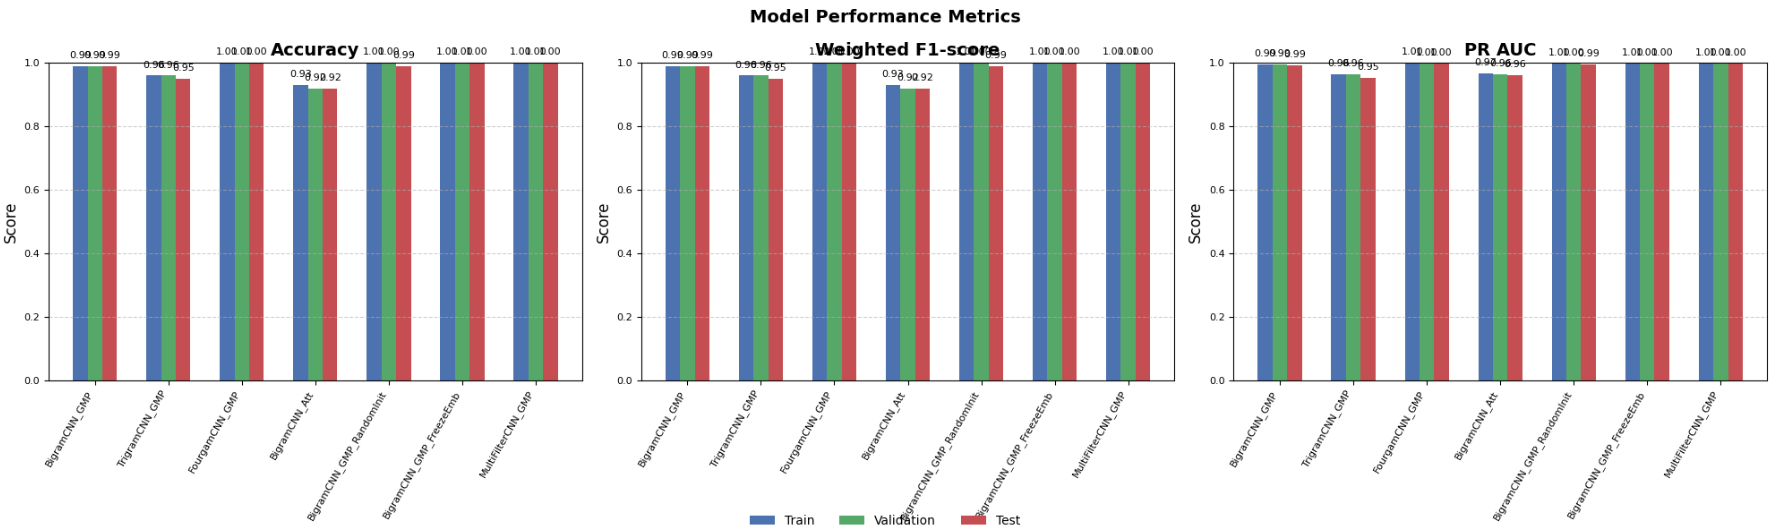

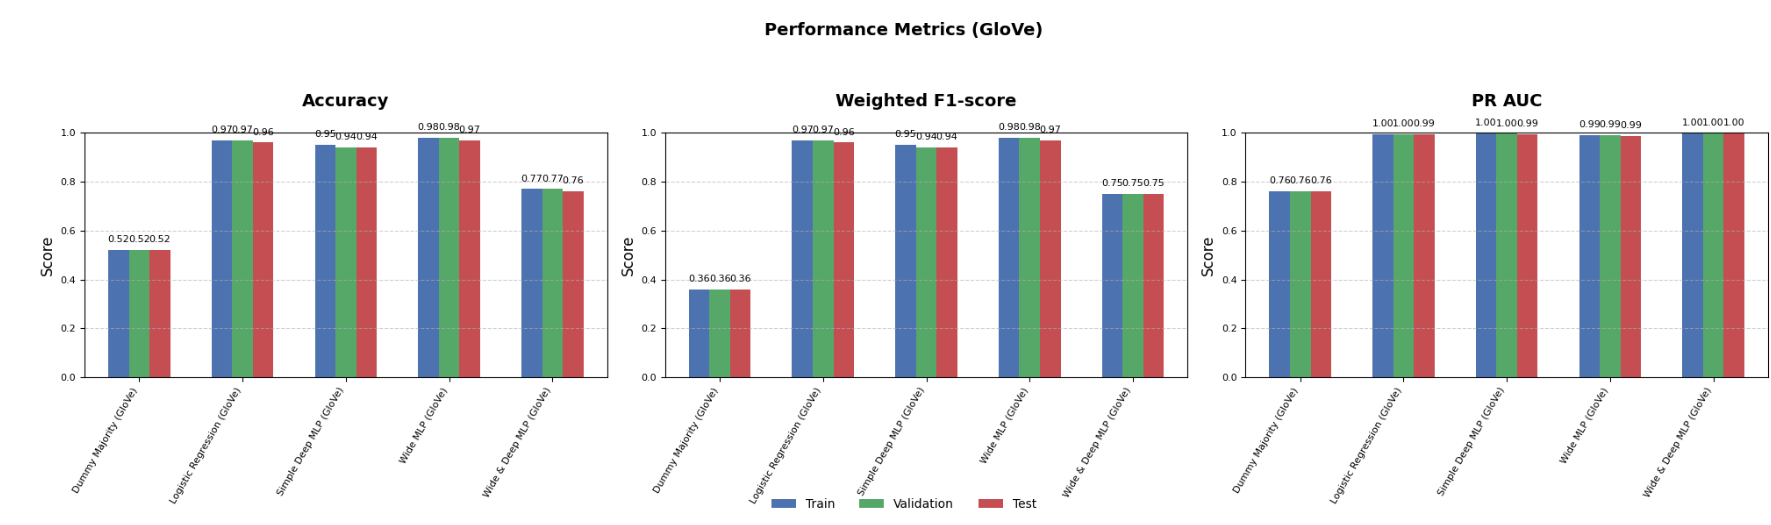

# Exercise 2

- Repeat Exercise 3 of Part 5 (POS tagger), by fine-tuning a pre-trained BERT model.

- Tune
the hyper-parameters on the development subset of your dataset.

- Monitor the performance of
your models on the development subset during training to decide how many epochs to use.

- If the sentences of your experiments exceed BERT’s maximum length limit, you may want to
truncate them at the maximum allowed length of BERT or use a BERT-like model that can
handle longer texts (e.g., Longformer).

- Include experimental results of a baseline that tags
each word with the most frequent tag it had in the training data; for words that were not
encountered in the training data, the baseline should return the most frequent tag (over all
words) of the training data.

- Also include experimental results of your best method from
exercise 10 of Part 3, exercise 2 of Part 4, exercise 3 of Part 5, now treated as additional
baselines.

- Otherwise, the contents of your report should be as in exercise 3 of Part 5, but now
with information and results for the experiments of this exercise.

- You may optionally include
(for extra bonus) indicative experimental results on a small subset of the test set (e.g., 10 test
examples) obtained by prompting an LLM (e.g., Chat-GPT), using appropriate instructions
and possibly including few-shot examples (demonstrators).

## Imports and Pip Installs

In [ ]:
!nvidia-smi

Mon Mar 10 18:29:38 2025       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 550.54.15              Driver Version: 550.54.15      CUDA Version: 12.4     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  Tesla T4                       Off |   00000000:00:04.0 Off |                    0 |
| N/A   54C    P8             10W /   70W |       0MiB /  15360MiB |      0%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+-----

In [ ]:
!pip install -U transformers datasets conllu evaluate seqeval

In [ ]:
import os
import torch
import conllu
import requests
import evaluate
import numpy as np
import pandas as pd
from tqdm import tqdm
from torch.optim import AdamW
import matplotlib.pyplot as plt
from datasets import load_dataset
from torch.utils.data import DataLoader
from datasets import DatasetDict, Dataset
from sklearn.preprocessing import label_binarize
from transformers import DataCollatorForTokenClassification
from sklearn.metrics import classification_report, roc_auc_score
from sklearn.metrics import accuracy_score, precision_recall_fscore_support, classification_report
from transformers import AutoTokenizer, AutoModelForTokenClassification, TrainingArguments, Trainer

## Data Download

In [ ]:
# URLs for the train, dev, and test data
urls = {
    "train": "https://raw.githubusercontent.com/UniversalDependencies/UD_English-EWT/master/en_ewt-ud-train.conllu",
    "dev": "https://raw.githubusercontent.com/UniversalDependencies/UD_English-EWT/master/en_ewt-ud-dev.conllu",
    "test": "https://raw.githubusercontent.com/UniversalDependencies/UD_English-EWT/master/en_ewt-ud-test.conllu"
}

# Function to download data from URLs
def download_data(url, filename):
    if os.path.exists(filename):
        print(f"{filename} already exists, skipping download.")
        return

    try:
        print(f"Downloading {filename}...")
        response = requests.get(url)
        response.raise_for_status()  # Raise an error for bad status codes
        with open(filename, 'w', encoding='utf-8') as file:
            file.write(response.text)
        print(f"Downloaded {filename}")
    except requests.exceptions.RequestException as e:
        print(f"Error downloading {filename}: {e}")

# Download train, dev, and test data
download_data(urls['train'], 'en_ewt-ud-train.conllu')
download_data(urls['dev'], 'en_ewt-ud-dev.conllu')
download_data(urls['test'], 'en_ewt-ud-test.conllu')


Downloaded en_ewt-ud-train.conllu
Downloaded en_ewt-ud-dev.conllu
Downloaded en_ewt-ud-test.conllu


## Data Parsing

In [ ]:
def parse_conllu(filename):
    sentences = []
    current_sentence = []

    try:
        with open(filename, 'r', encoding='utf-8') as file:
            for line in file:
                # Skip empty lines (separators between sentences)
                if not line.strip():
                    if current_sentence:
                        sentences.append(current_sentence)
                        current_sentence = []
                    continue

                # Skip comment lines (lines starting with '#')
                if line.startswith('#'):
                    continue

                # Split the line by tabs to get the columns
                columns = line.strip().split('\t')

                if len(columns) > 1:
                    word = columns[1]  # The word itself
                    pos_tag = columns[3]  # The POS tag
                    current_sentence.append((word, pos_tag))

            # Add the last sentence if the file doesn't end with an empty line
            if current_sentence:
                sentences.append(current_sentence)

        return sentences

    except FileNotFoundError:
        print(f"Error: File '{filename}' not found.")
        return []
    except Exception as e:
        print(f"Error parsing the file: {e}")
        return []

train_sentences = parse_conllu('en_ewt-ud-train.conllu')
dev_sentences = parse_conllu('en_ewt-ud-dev.conllu')
test_sentences = parse_conllu('en_ewt-ud-test.conllu')


In [ ]:
train_sentences[69]

[('This', 'PRON'),
 ('is', 'AUX'),
 ('not', 'PART'),
 ('a', 'DET'),
 ('post', 'NOUN'),
 ('about', 'ADP'),
 ('fault', 'NOUN'),
 ('-', 'PUNCT'),
 ('finding', 'NOUN'),
 ('or', 'CCONJ'),
 ('assigning', 'VERB'),
 ('blame', 'NOUN'),
 ('.', 'PUNCT')]

## Exploratory Data Analysis

In [ ]:
# Calculate the length of each sentence (in terms of the number of words)
sentence_lengths = [len(sentence) for sentence in train_sentences]

print("Mean train sentence length: ", np.mean(sentence_lengths))

Mean train sentence length:  16.520248724489797


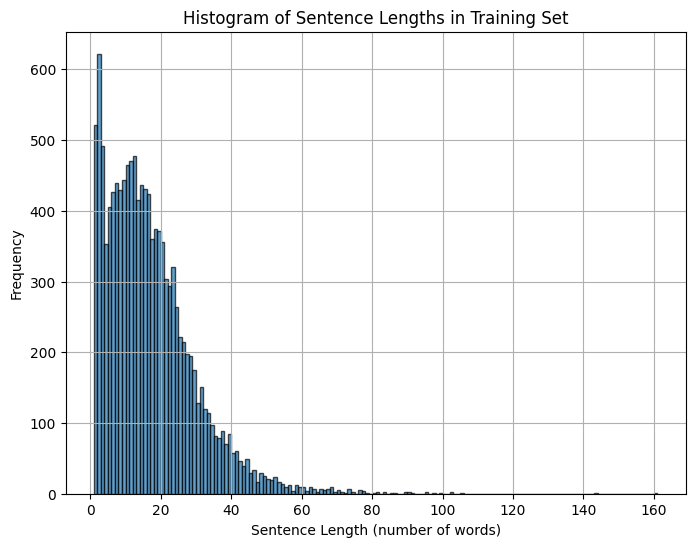

In [ ]:
plt.figure(figsize=(8, 6))
plt.hist(sentence_lengths, bins=range(1, max(sentence_lengths) + 2), edgecolor='black', alpha=0.7)
plt.title("Histogram of Sentence Lengths in Training Set")
plt.xlabel("Sentence Length (number of words)")
plt.ylabel("Frequency")
plt.grid(True)
plt.show()

### Downloading the equivalent dataset from Hugging Face

In [ ]:
dataset = load_dataset('universal_dependencies', 'en_ewt', trust_remote_code=True)
dataset

README.md:   0%|          | 0.00/191k [00:00<?, ?B/s]

universal_dependencies.py:   0%|          | 0.00/87.8k [00:00<?, ?B/s]

Generating train split:   0%|          | 0/12543 [00:00<?, ? examples/s]

Generating validation split:   0%|          | 0/2002 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/2077 [00:00<?, ? examples/s]

DatasetDict({
    train: Dataset({
        features: ['idx', 'text', 'tokens', 'lemmas', 'upos', 'xpos', 'feats', 'head', 'deprel', 'deps', 'misc'],
        num_rows: 12543
    })
    validation: Dataset({
        features: ['idx', 'text', 'tokens', 'lemmas', 'upos', 'xpos', 'feats', 'head', 'deprel', 'deps', 'misc'],
        num_rows: 2002
    })
    test: Dataset({
        features: ['idx', 'text', 'tokens', 'lemmas', 'upos', 'xpos', 'feats', 'head', 'deprel', 'deps', 'misc'],
        num_rows: 2077
    })
})

In [ ]:
train_sentences[5]

[('The', 'DET'),
 ('third', 'ADJ'),
 ('was', 'AUX'),
 ('being', 'AUX'),
 ('run', 'VERB'),
 ('by', 'ADP'),
 ('the', 'DET'),
 ('head', 'NOUN'),
 ('of', 'ADP'),
 ('an', 'DET'),
 ('investment', 'NOUN'),
 ('firm', 'NOUN'),
 ('.', 'PUNCT')]

In [ ]:
dataset['train'][5]

{'idx': 'weblog-juancole.com_juancole_20051126063000_ENG_20051126_063000-0006',
 'text': 'The third was being run by the head of an investment firm.',
 'tokens': ['The',
  'third',
  'was',
  'being',
  'run',
  'by',
  'the',
  'head',
  'of',
  'an',
  'investment',
  'firm',
  '.'],
 'lemmas': ['the',
  'third',
  'be',
  'be',
  'run',
  'by',
  'the',
  'head',
  'of',
  'a',
  'investment',
  'firm',
  '.'],
 'upos': [8, 6, 17, 17, 16, 2, 8, 0, 2, 8, 0, 0, 1],
 'xpos': ['DT',
  'JJ',
  'VBD',
  'VBG',
  'VBN',
  'IN',
  'DT',
  'NN',
  'IN',
  'DT',
  'NN',
  'NN',
  '.'],
 'feats': ["{'Definite': 'Def', 'PronType': 'Art'}",
  "{'Degree': 'Pos', 'NumType': 'Ord'}",
  "{'Mood': 'Ind', 'Number': 'Sing', 'Person': '3', 'Tense': 'Past', 'VerbForm': 'Fin'}",
  "{'VerbForm': 'Ger'}",
  "{'Tense': 'Past', 'VerbForm': 'Part', 'Voice': 'Pass'}",
  'None',
  "{'Definite': 'Def', 'PronType': 'Art'}",
  "{'Number': 'Sing'}",
  'None',
  "{'Definite': 'Ind', 'PronType': 'Art'}",
  "{'Number':

In [ ]:
list(zip(dataset['train'][5]['tokens'], dataset['train'][5]['xpos'], dataset['train'][5]['upos']))

[('The', 'DT', 8),
 ('third', 'JJ', 6),
 ('was', 'VBD', 17),
 ('being', 'VBG', 17),
 ('run', 'VBN', 16),
 ('by', 'IN', 2),
 ('the', 'DT', 8),
 ('head', 'NN', 0),
 ('of', 'IN', 2),
 ('an', 'DT', 8),
 ('investment', 'NN', 0),
 ('firm', 'NN', 0),
 ('.', '.', 1)]

In [ ]:
xpos_upos_tags_dictionary = {}

l = []
for split in dataset:
    for sentence in dataset[split]:
        for i, xtag in enumerate(sentence['xpos']):
            if xtag not in xpos_upos_tags_dictionary:
                xpos_upos_tags_dictionary[xtag] = []
            xpos_upos_tags_dictionary[xtag].append(sentence['upos'][i])

for x, u_list in xpos_upos_tags_dictionary.items():
  print("Xpos: ", x, " has the following upos: ",set(u_list))

Xpos:  NNP  has the following upos:  {0, 10, 12, 6}
Xpos:  HYPH  has the following upos:  {1}
Xpos:  :  has the following upos:  {1}
Xpos:  JJ  has the following upos:  {0, 6, 10, 14, 15}
Xpos:  NNS  has the following upos:  {0, 16}
Xpos:  VBD  has the following upos:  {16, 17}
Xpos:  ,  has the following upos:  {1, 4}
Xpos:  DT  has the following upos:  {8, 11, 6}
Xpos:  NN  has the following upos:  {0, 3, 4, 6, 10, 11, 12, 14, 15}
Xpos:  IN  has the following upos:  {2, 4, 5, 14}
Xpos:  .  has the following upos:  {1}
Xpos:  -LRB-  has the following upos:  {1}
Xpos:  MD  has the following upos:  {17}
Xpos:  VB  has the following upos:  {16, 17}
Xpos:  VBG  has the following upos:  {16, 17, 0, 6}
Xpos:  PRP  has the following upos:  {11}
Xpos:  TO  has the following upos:  {2, 7}
Xpos:  -RRB-  has the following upos:  {1}
Xpos:  VBN  has the following upos:  {16, 17}
Xpos:  RP  has the following upos:  {2, 14}
Xpos:  CD  has the following upos:  {3}
Xpos:  VBZ  has the following upos:

### Xpos Appendix

1. **NNP** - Proper noun, singular (e.g., "John")
2. **HYPH** - Hyphen (used in hyphenated words)
3. **:** - Punctuation mark (colon)
4. **JJ** - Adjective (e.g., "beautiful")
5. **NNS** - Noun, plural (e.g., "dogs")
6. **VBD** - Verb, past tense (e.g., "walked")
7. **,** - Comma
8. **DT** - Determiner (e.g., "the", "a")
9. **NN** - Noun, singular (e.g., "dog")
10. **IN** - Preposition or subordinating conjunction (e.g., "in", "on", "because")
11. **.** - Period (full stop)
12. **-LRB-** - Left round bracket (open parenthesis)
13. **MD** - Modal verb (e.g., "can", "will")
14. **VB** - Verb, base form (e.g., "run")
15. **VBG** - Verb, gerund or present participle (e.g., "running")
16. **PRP** - Personal pronoun (e.g., "I", "he", "she")
17. **TO** - To (used for the infinitive form of a verb, e.g., "to run")
18. **-RRB-** - Right round bracket (close parenthesis)
19. **VBN** - Verb, past participle (e.g., "eaten")
20. **RP** - Particle (e.g., "up" in "give up")
21. **CD** - Cardinal number (e.g., "one", "two", "three")
22. **VBZ** - Verb, 3rd person singular present (e.g., "runs")
23. **RB** - Adverb (e.g., "quickly")
24. **NNPS** - Proper noun, plural (e.g., "Americas")
25. **VBP** - Verb, non-3rd person singular present (e.g., "run")
26. **PRP\$** - Possessive pronoun (e.g., "my", "his")
27. **CC** - Coordinating conjunction (e.g., "and", "or")
28. **None** - Used for tokens without a specific UPOS tag
29. **WP** - Wh-pronoun (e.g., "who", "what")
30. **EX** - Existential there (e.g., "there is")
31. **WDT** - Wh-determiner (e.g., "which")
32. **RBR** - Adverb, comparative (e.g., "better")
33. **PDT** - Predeterminer (e.g., "all", "both")
34. **JJR** - Adjective, comparative (e.g., "bigger")
35. **WRB** - Wh-adverb (e.g., "where", "when")
36. **JJS** - Adjective, superlative (e.g., "biggest")
37. **``** - Opening quotation mark (e.g., "quote)
38. **''** - Closing quotation mark (e.g., "quote")
39. **POS** - Possessive ending (e.g., "John's")
40. **RBS** - Adverb, superlative (e.g., "best")
41. **WP$** - Possessive wh-pronoun (e.g., "whose")
42. **ADD** - Additional word (usually for things like "etc." or "and so on")
43. **FW** - Foreign word (e.g., "pizza")
44. **LS** - List item marker (e.g., "1.", "a)")
45. **UH** - Interjection (e.g., "wow", "ouch")
46. **AFX** - Affix (e.g., "-ing", "-ly")
47. **\$** - Dollar sign (e.g., "\$10")
48. **NFP** - Non-final punctuation (e.g., semicolons, ellipses)
49. **SYM** - Symbol (e.g., "%", "&")
50. **GW** - Discourse marker or "general word" (used for words like "thing" or "stuff")
51. **XX** - Unknown word or symbol (e.g., non-lexical tokens)


We can see that the Hugging Face Universal Dependencies dataset contains a whole lot more of POS Tags than the one from the Github [repository](https://github.com/UniversalDependencies/UD_English-EWT).

## Data Preprocessing

In [ ]:
def convert_to_dataset(sentences):

    sentence_texts = []
    pos_tags = []

    for sentence in sentences:
        words = [word for word, pos in sentence]
        tags = [pos for word, pos in sentence]

        sentence_texts.append(words)
        pos_tags.append(tags)

    data = {
        'sentence': sentence_texts,
        'pos_tags': pos_tags
    }

    # Convert to a Hugging Face Dataset
    return Dataset.from_dict(data)

train_dataset = convert_to_dataset(train_sentences)
dev_dataset = convert_to_dataset(dev_sentences)
test_dataset = convert_to_dataset(test_sentences)

In [ ]:
Complete_dataset = DatasetDict({
    "train": train_dataset.shuffle(),
    "dev": dev_dataset,
    "test": test_dataset
})

Complete_dataset

DatasetDict({
    train: Dataset({
        features: ['sentence', 'pos_tags'],
        num_rows: 12544
    })
    dev: Dataset({
        features: ['sentence', 'pos_tags'],
        num_rows: 2001
    })
    test: Dataset({
        features: ['sentence', 'pos_tags'],
        num_rows: 2077
    })
})

In [ ]:
unique_tags = set(tag for split in Complete_dataset for tags in Complete_dataset[split]['pos_tags'] for tag in tags)
label2id = {label: i for i, label in enumerate(sorted(unique_tags))}
id2label = {i: label for label, i in label2id.items()}


print("Unique tags:", unique_tags)
print("Label to ID mapping:", label2id)
print("ID to Label mapping:", id2label)

Unique tags: {'ADP', 'NUM', 'X', 'VERB', 'INTJ', 'PRON', 'PUNCT', 'PROPN', 'NOUN', 'SCONJ', '_', 'CCONJ', 'ADV', 'AUX', 'PART', 'ADJ', 'DET', 'SYM'}
Label to ID mapping: {'ADJ': 0, 'ADP': 1, 'ADV': 2, 'AUX': 3, 'CCONJ': 4, 'DET': 5, 'INTJ': 6, 'NOUN': 7, 'NUM': 8, 'PART': 9, 'PRON': 10, 'PROPN': 11, 'PUNCT': 12, 'SCONJ': 13, 'SYM': 14, 'VERB': 15, 'X': 16, '_': 17}
ID to Label mapping: {0: 'ADJ', 1: 'ADP', 2: 'ADV', 3: 'AUX', 4: 'CCONJ', 5: 'DET', 6: 'INTJ', 7: 'NOUN', 8: 'NUM', 9: 'PART', 10: 'PRON', 11: 'PROPN', 12: 'PUNCT', 13: 'SCONJ', 14: 'SYM', 15: 'VERB', 16: 'X', 17: '_'}


Converting POS Tag to label numbers.

In [ ]:
Complete_dataset = Complete_dataset.map(lambda example: {'pos_tags': [label2id[tag] for tag in example['pos_tags']]})

Map:   0%|          | 0/12544 [00:00<?, ? examples/s]

Map:   0%|          | 0/2001 [00:00<?, ? examples/s]

Map:   0%|          | 0/2077 [00:00<?, ? examples/s]

In [ ]:
Complete_dataset['train'][0]

{'sentence': ['A',
  'key',
  'question',
  'is',
  'how',
  'they',
  'acquired',
  'the',
  'anthrax',
  'strain',
  'first',
  'isolated',
  'by',
  'the',
  'Texas',
  'Veterinary',
  'Medical',
  'Diagnostic',
  'Lab',
  'in',
  '1980',
  '.'],
 'pos_tags': [5,
  0,
  7,
  3,
  2,
  10,
  15,
  5,
  7,
  7,
  2,
  15,
  1,
  5,
  11,
  0,
  0,
  0,
  11,
  1,
  8,
  12]}

## Transformers Training and Evaluation

In [ ]:
def compute_metrics(p):
    """
    p (tuple): A tuple containing the predictions and the true labels.
               p[0] - logits (predictions from the model)
               p[1] - labels (true labels)

    """


    logits, labels = p
    # Convert logits to predictions (we take the index of the highest logit)
    predictions = torch.argmax(torch.tensor(logits), axis=-1)

    # Flatten both predictions and labels for comparison
    predictions = predictions.flatten()
    labels = labels.flatten()

    # Ignore padding tokens (usually labeled as -100)
    mask = labels != -100

    # Filter out the padding tokens from predictions and labels
    predictions = predictions[mask]
    labels = labels[mask]


    precision, recall, f1, _ = precision_recall_fscore_support(labels, predictions, average='micro', zero_division=1)
    accuracy = accuracy_score(labels, predictions)

    return {
        "precision": precision,
        "recall": recall,
        "f1": f1,
        "accuracy": accuracy,
    }

In [ ]:
def train_pos_tagger(model_name, output_dir='./results', logging_dir='./logs', logging_steps=150, learning_rate=2e-5, per_device_train_batch_size=16, per_device_eval_batch_size=16, num_train_epochs=1, weight_decay=0.01):


    tokenizer = AutoTokenizer.from_pretrained(model_name)
    model = AutoModelForTokenClassification.from_pretrained(model_name, label2id = label2id, id2label = id2label)


    # Ensure model is sent to the appropriate device
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model.to(device)


    # Tokenize the dataset
    def tokenize_and_align_labels(examples):
        tokenized_inputs = tokenizer(examples["sentence"], padding=True,truncation=True, is_split_into_words=True)

        labels = []
        for i, label in enumerate(examples["pos_tags"]):
            word_ids = tokenized_inputs.word_ids(batch_index=i)  # Map tokens to their respective word.
            previous_word_idx = None
            label_ids = []
            for word_idx in word_ids:  # Set the special tokens to -100. [CLS] etc
                if word_idx is None:
                    label_ids.append(-100)
                elif word_idx != previous_word_idx:  # Only label the first token of a given word.
                    label_ids.append(label[word_idx])
                else:
                    label_ids.append(-100)
                previous_word_idx = word_idx
            labels.append(label_ids)

        tokenized_inputs["labels"] = labels
        return tokenized_inputs

    tokenized_datasets = Complete_dataset.map(tokenize_and_align_labels, batched=True, remove_columns=Complete_dataset["train"].column_names)


    data_collator = DataCollatorForTokenClassification(tokenizer)

#===========================================================================================================================================

    training_args = TrainingArguments(
        output_dir=output_dir,
        logging_dir=logging_dir,
        logging_steps=logging_steps,
        learning_rate=learning_rate,
        per_device_train_batch_size=per_device_train_batch_size,
        per_device_eval_batch_size=per_device_eval_batch_size,
        num_train_epochs=num_train_epochs,
        weight_decay=weight_decay,
        eval_strategy="epoch",
        save_strategy="epoch",
        load_best_model_at_end=True,
        report_to='none'
    )

    trainer = Trainer(
        model=model,
        args=training_args,
        train_dataset=tokenized_datasets["train"],
        eval_dataset=tokenized_datasets["dev"],
        data_collator=data_collator,
        compute_metrics = compute_metrics,
    )


    trainer.train()

#===========================================================================================================================================

    predictions = trainer.predict(tokenized_datasets["test"])

    # Unpack the results (logits and labels)
    logits = predictions.predictions
    labels = predictions.label_ids

    # Convert logits to probabilities (using softmax)
    probs = torch.nn.functional.softmax(torch.tensor(logits), dim=-1).numpy()

    auc_scores = {}

    # Flatten the logits and labels, but only for valid tokens (not special tokens)
    true_labels_flat = []
    prob_flat = []

    for i, label_sequence in enumerate(labels):
        valid_token_indices = [j for j, l in enumerate(label_sequence) if l != -100]  # Get indices where label is not -100
        true_labels_flat.extend([label_sequence[j] for j in valid_token_indices])  # Add valid true labels
        prob_flat.extend([probs[i, j] for j in valid_token_indices])  # Add valid probabilities

    true_labels_flat = np.array(true_labels_flat)
    prob_flat = np.array(prob_flat)

    # Calculate AUC score for each tag (class)
    for tag_id in range(len(id2label)):

        # Convert true labels for the current tag to binary format
        true_labels_tag = (true_labels_flat == tag_id).astype(int)


        auc = roc_auc_score(true_labels_tag, prob_flat[:, tag_id])
        auc_scores[id2label[tag_id]] = auc


    # Convert logits to predicted labels (argmax over logits)
    pred_labels = torch.argmax(torch.tensor(logits), axis=-1).cpu().numpy()

    # Flatten predictions and labels for classification report
    pred_labels = pred_labels.flatten()
    labels = labels.flatten()

    # Mask out padding tokens (usually labeled as -100)
    mask = labels != -100

    # Filter out padding tokens from predictions and labels
    filtered_pred_labels = pred_labels[mask]
    filtered_labels = labels[mask]

    report = classification_report(filtered_labels, filtered_pred_labels, target_names=list(id2label.values()), zero_division=1)



    print("Classification Report")
    print(report)




    print("AUC scores per tag (class):")
    for tag, auc in auc_scores.items():
        print(f"{tag}: {auc:.4f}")

#===========================================================================================================================================

    return model, tokenizer, trainer

In [ ]:
model, tokenizer, trainer = train_pos_tagger("xlm-roberta-base")

Map:   0%|          | 0/12544 [00:00<?, ? examples/s]

Map:   0%|          | 0/2001 [00:00<?, ? examples/s]

Map:   0%|          | 0/2077 [00:00<?, ? examples/s]

Epoch,Training Loss,Validation Loss,Precision,Recall,F1,Accuracy
1,0.110100,0.117467,0.968485,0.968485,0.968485,0.968485


Classification Report
              precision    recall  f1-score   support

         ADJ       0.94      0.95      0.95      1794
         ADP       0.97      0.99      0.98      2030
         ADV       0.94      0.95      0.94      1183
         AUX       0.99      0.99      0.99      1543
       CCONJ       1.00      0.99      0.99       736
         DET       0.99      0.99      0.99      1896
        INTJ       0.86      0.88      0.87       121
        NOUN       0.96      0.95      0.96      4123
         NUM       0.94      0.99      0.97       542
        PART       1.00      1.00      1.00       649
        PRON       0.99      0.99      0.99      2166
       PROPN       0.92      0.92      0.92      2076
       PUNCT       1.00      1.00      1.00      3096
       SCONJ       0.97      0.94      0.96       384
         SYM       0.84      0.86      0.85       109
        VERB       0.98      0.98      0.98      2606
           X       1.00      0.00      0.00        42
     

In [ ]:
model, tokenizer, trainer = train_pos_tagger("bert-base-uncased")

tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

Map:   0%|          | 0/12544 [00:00<?, ? examples/s]

Map:   0%|          | 0/2001 [00:00<?, ? examples/s]

Map:   0%|          | 0/2077 [00:00<?, ? examples/s]

Epoch,Training Loss,Validation Loss,Precision,Recall,F1,Accuracy
1,0.122100,0.135049,0.964526,0.964526,0.964526,0.964526


Classification Report
              precision    recall  f1-score   support

         ADJ       0.94      0.95      0.95      1794
         ADP       0.98      0.98      0.98      2030
         ADV       0.96      0.94      0.95      1183
         AUX       0.99      0.99      0.99      1543
       CCONJ       1.00      0.99      1.00       736
         DET       0.99      0.99      0.99      1896
        INTJ       0.94      0.84      0.89       121
        NOUN       0.93      0.95      0.94      4123
         NUM       0.94      0.98      0.96       542
        PART       0.99      0.99      0.99       649
        PRON       0.99      1.00      0.99      2166
       PROPN       0.92      0.88      0.90      2076
       PUNCT       0.99      0.99      0.99      3096
       SCONJ       0.95      0.96      0.96       384
         SYM       0.76      0.80      0.78       109
        VERB       0.98      0.99      0.98      2606
           X       1.00      0.00      0.00        42
     

In [ ]:
model, tokenizer, trainer = train_pos_tagger("t5-base")

config.json:   0%|          | 0.00/1.21k [00:00<?, ?B/s]

spiece.model:   0%|          | 0.00/792k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.39M [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/892M [00:00<?, ?B/s]

Map:   0%|          | 0/12544 [00:00<?, ? examples/s]

Map:   0%|          | 0/2001 [00:00<?, ? examples/s]

Map:   0%|          | 0/2077 [00:00<?, ? examples/s]

Epoch,Training Loss,Validation Loss,Precision,Recall,F1,Accuracy
1,2.528200,2.050722,0.473307,0.473307,0.473307,0.473307


Classification Report
              precision    recall  f1-score   support

         ADJ       0.31      0.15      0.20      1794
         ADP       0.21      0.90      0.34      2030
         ADV       0.13      0.04      0.07      1183
         AUX       0.09      0.01      0.02      1543
       CCONJ       0.32      0.07      0.11       736
         DET       0.64      0.35      0.45      1896
        INTJ       0.00      0.00      0.00       121
        NOUN       0.65      0.61      0.63      4123
         NUM       0.69      0.25      0.37       542
        PART       0.09      0.03      0.04       649
        PRON       0.67      0.61      0.64      2166
       PROPN       0.67      0.55      0.61      2076
       PUNCT       0.87      0.91      0.89      3096
       SCONJ       0.04      0.05      0.05       384
         SYM       0.00      0.00      0.00       109
        VERB       0.49      0.41      0.45      2606
           X       0.00      0.00      0.00        42
     

In [ ]:
model, tokenizer, trainer = train_pos_tagger("nlpaueb/bert-base-uncased-eurlex")  # pre-trained on EU legislation

tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/1.00k [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/440M [00:00<?, ?B/s]

Map:   0%|          | 0/12544 [00:00<?, ? examples/s]

model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

Map:   0%|          | 0/2001 [00:00<?, ? examples/s]

Map:   0%|          | 0/2077 [00:00<?, ? examples/s]

Epoch,Training Loss,Validation Loss,Precision,Recall,F1,Accuracy
1,0.133500,0.153926,0.959235,0.959235,0.959235,0.959235


Classification Report
              precision    recall  f1-score   support

         ADJ       0.93      0.94      0.94      1794
         ADP       0.97      0.98      0.97      2030
         ADV       0.95      0.93      0.94      1183
         AUX       0.99      0.99      0.99      1543
       CCONJ       1.00      0.99      0.99       736
         DET       0.99      1.00      0.99      1896
        INTJ       0.93      0.83      0.87       121
        NOUN       0.93      0.95      0.94      4123
         NUM       0.92      0.98      0.95       542
        PART       0.99      1.00      0.99       649
        PRON       0.99      0.99      0.99      2166
       PROPN       0.92      0.87      0.89      2076
       PUNCT       0.99      1.00      0.99      3096
       SCONJ       0.96      0.96      0.96       384
         SYM       0.83      0.78      0.81       109
        VERB       0.97      0.99      0.98      2606
           X       1.00      0.00      0.00        42
     

In [ ]:
model, tokenizer, trainer = train_pos_tagger("nlpaueb/sec-bert-base")   # pre-trained on 260,773 10-K filings from 1993-2019

tokenizer_config.json:   0%|          | 0.00/263 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/568 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/221k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/439M [00:00<?, ?B/s]

Map:   0%|          | 0/12544 [00:00<?, ? examples/s]

model.safetensors:   0%|          | 0.00/439M [00:00<?, ?B/s]

Map:   0%|          | 0/2001 [00:00<?, ? examples/s]

Map:   0%|          | 0/2077 [00:00<?, ? examples/s]

Epoch,Training Loss,Validation Loss,Precision,Recall,F1,Accuracy
1,0.148700,0.166297,0.954649,0.954649,0.954649,0.954649


Classification Report
              precision    recall  f1-score   support

         ADJ       0.91      0.92      0.92      1794
         ADP       0.97      0.97      0.97      2030
         ADV       0.93      0.91      0.92      1183
         AUX       0.99      0.99      0.99      1543
       CCONJ       1.00      0.99      1.00       736
         DET       0.99      0.99      0.99      1896
        INTJ       0.81      0.59      0.68       121
        NOUN       0.93      0.94      0.93      4123
         NUM       0.93      0.98      0.95       542
        PART       0.98      0.99      0.98       649
        PRON       0.99      0.99      0.99      2166
       PROPN       0.88      0.87      0.87      2076
       PUNCT       0.99      0.99      0.99      3096
       SCONJ       0.94      0.94      0.94       384
         SYM       0.80      0.83      0.81       109
        VERB       0.96      0.97      0.97      2606
           X       1.00      0.00      0.00        42
     

## Comparison Board

| **Model**                | **Accuracy** | **Macro avg F1-score** | **Weighted avg F1-score** | **Strengths**                                                                                                                                     | **Weaknesses**                                                                                                             |
|--------------------------|--------------|------------------------|---------------------------|--------------------------------------------------------------------------------------------------------------------------------------------------|---------------------------------------------------------------------------------------------------------------------------|
| **ShallowPOS_MLP**        | 0.83         | 0.74                   | 0.83                      | High performance on **PRON (0.97 precision)**, **AUX (0.96 recall)**, and **VERB (0.91 f1-score)**.                                               | Struggles with **X (f1 = 0.00)** and **CCONJ (0.45 f1)**.                                                                |
| **DeepPOS_MLP**          | 0.83         | 0.74                   | 0.83                      | Improved recall for **AUX (0.94)** and **PRON (0.97)**, maintains strong performance across categories.                                           | Struggles with rare categories like **X**.                                                                                 |
| **VeryDeepPOS_MLP**      | 0.82         | 0.74                   | 0.82                      | Strong performance on **AUX** and **PRON**, but slightly lower overall performance compared to other MLP models.                                  | Some decrease in performance, especially in **CCONJ (0.43 f1)** and **NUM (0.56 f1)**.                                     |
| **ShallowPOS_BiGRU**     | 0.84         | 0.75                   | 0.84                      | High performance on **PRON (0.97 precision)**, **AUX (0.97 recall)**, and **VERB (0.92 f1-score)**.                                               | Struggles with **X (f1 = 0.04)** and **CCONJ (0.45 f1)**.                                                                |
| **DeepPOS_BiGRU**       | 0.84         | 0.75                   | 0.84                      | High performance on **AUX (0.97)** and **PRON (0.97)**.                                                                                          | Struggles with **X** and **CCONJ (0.45 f1)**.                                                                             |
| **VeryDeepPOS_BiGRU**   | 0.84         | 0.76                   | 0.84                      | Strong performance on **AUX (0.97)**, **PRON (0.98)**, and **VERB (0.92)** with a good balance across categories.                                | Some degradation in performance for **CCONJ (0.46 f1)** and **NUM (0.57 f1)**, but more consistent than previous models.  |
| **ShallowPOS_CNN**       | 0.83         | 0.74                   | 0.83                      | High performance on **AUX (0.96 recall)** and **PRON (0.97 precision)**, **PUNCT (0.99 recall)**.                                                 | Struggles with **X (f1 = 0.00)** and **CCONJ (0.43 f1)**.                                                                |
| **DeepPOS_CNN**         | 0.84         | 0.75                   | 0.84                      | Good performance across most categories, especially **AUX (0.97)** and **VERB (0.92)**.                                                           | Struggles with **X (f1 = 0.00)** and **CCONJ (0.47 f1)**.                                                                |
| **VeryDeepPOS_CNN**     | 0.82         | 0.73                   | 0.82                      | Strong performance on **AUX (0.96)** and **PRON (0.97)**.                                                                                       | Some struggles with **CCONJ (0.45 f1)** and **NUM (0.49 f1)**.                                                           |
| **Baseline Tagger**      | 0.86         | 0.80                   | 0.86                      | High accuracy and strong performance on **CCONJ (0.99 precision)** and **PUNCT (0.99 precision)**.                                                | Struggles with **X (f1 = 0.00)** and **PROPN (0.66 f1)**.                                                                |
| **XLM-RoBERTa Base**    | 0.97         | 0.91                   | 0.97                      | Outstanding performance across most categories, especially **AUX (0.99)**, **PUNCT (1.00)**, and **CCONJ (0.99)**. Very high accuracy and AUC scores. | Struggles with **X (f1 = 0.00)**.                                                                                         |
| **BERT Base Uncased**   | 0.97         | 0.90                   | 0.96                      | Strong performance across most categories, particularly **AUX (0.99)**, **CCONJ (1.00)**, and **PUNCT (0.99)**. Excellent AUC scores.              | Struggles with **X (f1 = 0.00)**.                                                                                         |
| **T5 Base**             | 0.47         | 0.27                   | 0.45                      | High precision for certain tags like **ADP (0.90 recall)** and **PUNCT (0.91 recall)**.                                                            | Struggles significantly with many categories, including **X (f1 = 0.00)**, **INTJ (f1 = 0.00)**, and **AUX (f1 = 0.02)**.  |
| **NLPAueb BERT Base Uncased (EURLEX)** | 0.96         | 0.90                   | 0.96                      | Strong performance across most categories, especially **AUX (0.99)**, **PUNCT (1.00)**, and **CCONJ (0.99)**. High AUC scores.                     | Struggles with **X (f1 = 0.00)**.                                                                                         |
| **NLPAueb SEC BERT Base** | 0.95         | 0.88                   | 0.95                      | Strong performance across most categories, particularly **AUX (0.99)**, **PUNCT (0.99)**, and **CCONJ (1.00)**. Very good AUC scores.              | Struggles with **X (f1 = 0.00)** and **INTJ (0.68 f1)**.                                                                  |

## Bonus Task

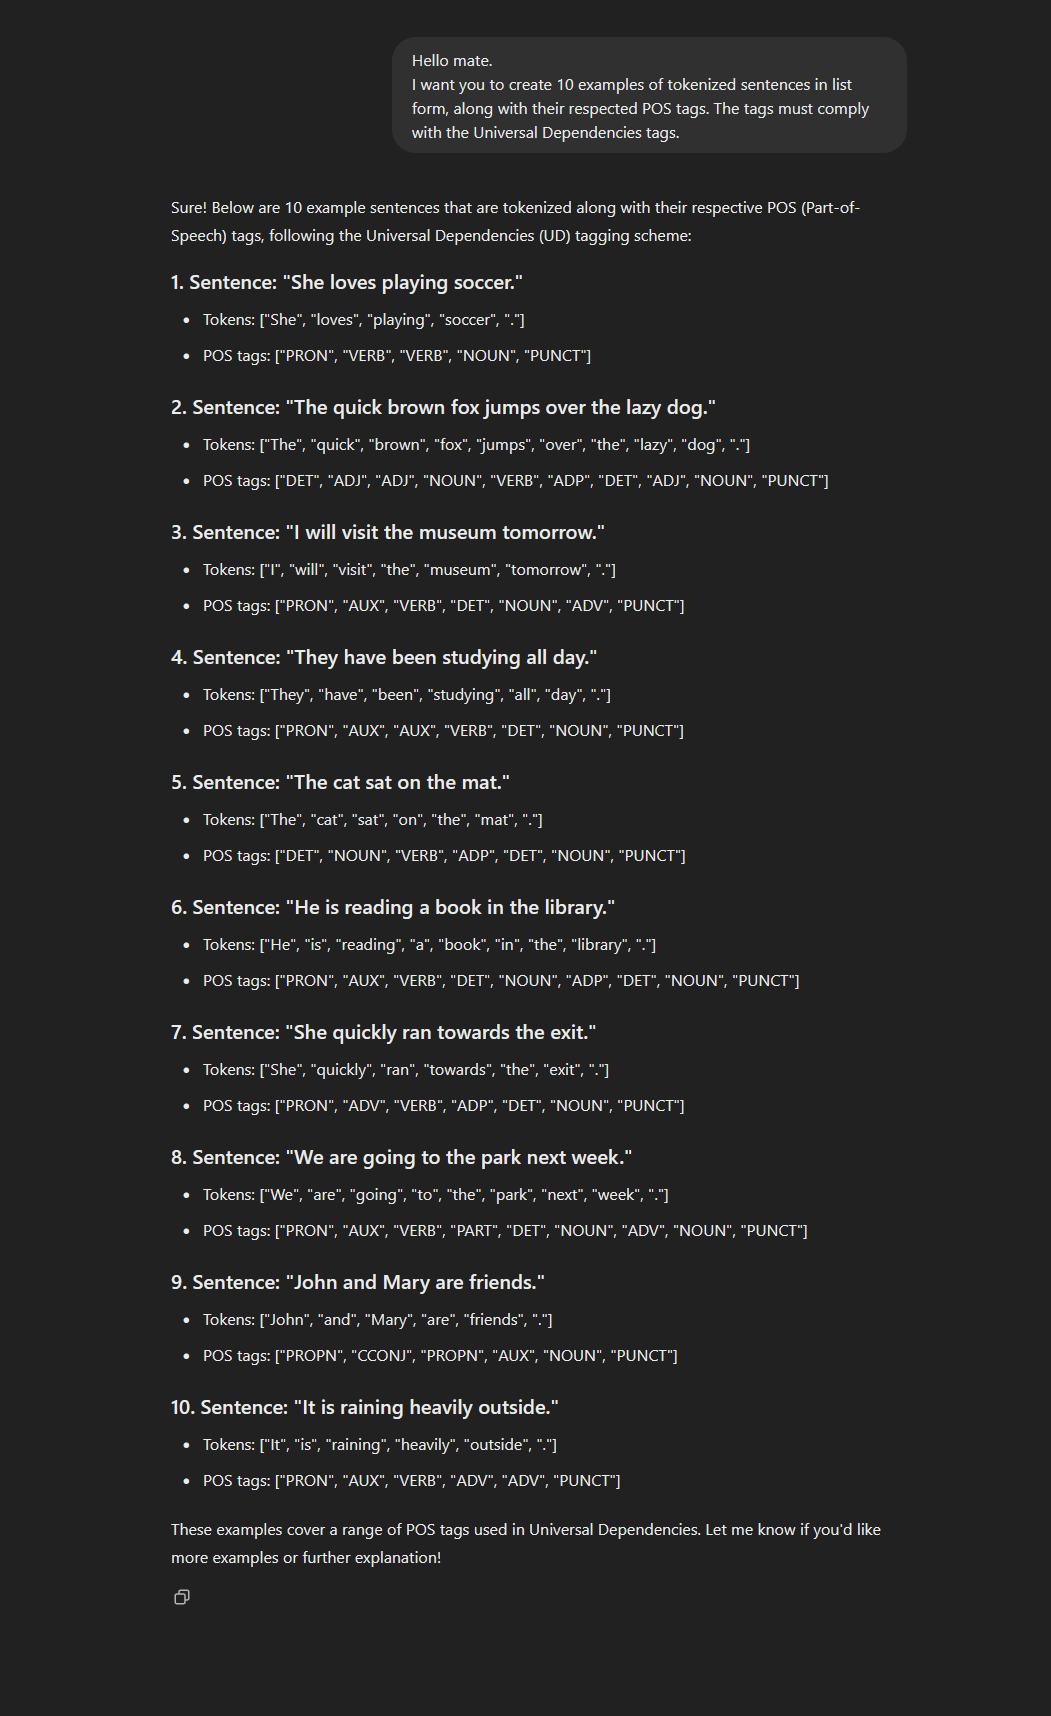

In [ ]:
sentences = [
    ["She", "loves", "playing", "soccer", "."],
    ["The", "quick", "brown", "fox", "jumps", "over", "the", "lazy", "dog", "."],
    ["I", "will", "visit", "the", "museum", "tomorrow", "."],
    ["They", "have", "been", "studying", "all", "day", "."],
    ["The", "cat", "sat", "on", "the", "mat", "."],
    ["He", "is", "reading", "a", "book", "in", "the", "library", "."],
    ["She", "quickly", "ran", "towards", "the", "exit", "."],
    ["We", "are", "going", "to", "the", "park", "next", "week", "."],
    ["John", "and", "Mary", "are", "friends", "."],
    ["It", "is", "raining", "heavily", "outside", "."]
]

pos_tags = [
    ["PRON", "VERB", "VERB", "NOUN", "PUNCT"],
    ["DET", "ADJ", "ADJ", "NOUN", "VERB", "ADP", "DET", "ADJ", "NOUN", "PUNCT"],
    ["PRON", "AUX", "VERB", "DET", "NOUN", "ADV", "PUNCT"],
    ["PRON", "AUX", "AUX", "VERB", "DET", "NOUN", "PUNCT"],
    ["DET", "NOUN", "VERB", "ADP", "DET", "NOUN", "PUNCT"],
    ["PRON", "AUX", "VERB", "DET", "NOUN", "ADP", "DET", "NOUN", "PUNCT"],
    ["PRON", "ADV", "VERB", "ADP", "DET", "NOUN", "PUNCT"],
    ["PRON", "AUX", "VERB", "PART", "DET", "NOUN", "ADV", "NOUN", "PUNCT"],
    ["PROPN", "CCONJ", "PROPN", "AUX", "NOUN", "PUNCT"],
    ["PRON", "AUX", "VERB", "ADV", "ADV", "PUNCT"]
]

data = [{"sentence": sentence, "pos_tags": pos_tag} for sentence, pos_tag in zip(sentences, pos_tags)]

df = pd.DataFrame(data)

prompt_dataset = Dataset.from_pandas(df)

prompt_dataset

Dataset({
    features: ['sentence', 'pos_tags'],
    num_rows: 10
})

In [ ]:
prompt_dataset = prompt_dataset.map(lambda example: {'pos_tags': [label2id[tag] for tag in example['pos_tags']]})

Map:   0%|          | 0/10 [00:00<?, ? examples/s]

In [ ]:
# Tokenize the dataset
def tokenize_and_align_labels(examples):
    tokenized_inputs = tokenizer(examples["sentence"], padding=True,truncation=True, is_split_into_words=True)

    labels = []
    for i, label in enumerate(examples["pos_tags"]):
        word_ids = tokenized_inputs.word_ids(batch_index=i)  # Map tokens to their respective word.
        previous_word_idx = None
        label_ids = []
        for word_idx in word_ids:  # Set the special tokens to -100. [CLS] etc
            if word_idx is None:
                label_ids.append(-100)
            elif word_idx != previous_word_idx:  # Only label the first token of a given word.
                label_ids.append(label[word_idx])
            else:
                label_ids.append(-100)
            previous_word_idx = word_idx
        labels.append(label_ids)

    tokenized_inputs["labels"] = labels
    return tokenized_inputs

tokenized_prompt_dataset = prompt_dataset.map(tokenize_and_align_labels, batched=True,)

training_args = TrainingArguments(
    output_dir="./results",  # Output directory
    eval_strategy="epoch",  # Evaluation strategy (e.g., after every epoch)
    report_to='none',
)

trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=tokenized_prompt_dataset,
    eval_dataset=tokenized_prompt_dataset,  # Here using the same dataset for simplicity
    compute_metrics = compute_metrics
)

# Evaluate the model
results = trainer.evaluate()

pd.DataFrame([results])

Map:   0%|          | 0/10 [00:00<?, ? examples/s]

,eval_loss,eval_model_preparation_time,eval_precision,eval_recall,eval_f1,eval_accuracy,eval_runtime,eval_samples_per_second,eval_steps_per_second
0,0.256491,0.0048,0.945205,0.945205,0.945205,0.945205,0.0543,184.159,36.832


In [ ]:
predictions = trainer.predict(tokenized_prompt_dataset)

# Unpack the results (logits and labels)
logits = predictions.predictions
labels = predictions.label_ids

# Convert logits to probabilities (using softmax)
probs = torch.nn.functional.softmax(torch.tensor(logits), dim=-1).numpy()

auc_scores = {}

# Flatten the logits and labels, but only for valid tokens (not special tokens)
true_labels_flat = []
prob_flat = []

for i, label_sequence in enumerate(labels):
    valid_token_indices = [j for j, l in enumerate(label_sequence) if l != -100]  # Get indices where label is not -100
    true_labels_flat.extend([label_sequence[j] for j in valid_token_indices])  # Add valid true labels
    prob_flat.extend([probs[i, j] for j in valid_token_indices])  # Add valid probabilities

true_labels_flat = np.array(true_labels_flat)
prob_flat = np.array(prob_flat)

# Calculate AUC score for each tag (class)
for tag_id in range(len(id2label)):
    # Convert true labels for the current tag to binary format
    true_labels_tag = (true_labels_flat == tag_id).astype(int)

    # Calculate AUC score
    auc = roc_auc_score(true_labels_tag, prob_flat[:, tag_id])
    auc_scores[id2label[tag_id]] = auc



# Convert logits to predicted labels (argmax over logits)
pred_labels = torch.argmax(torch.tensor(logits), axis=-1).cpu().numpy()

# Flatten predictions and labels for classification report
pred_labels = pred_labels.flatten()
labels = labels.flatten()

# Mask out padding tokens (usually labeled as -100)
mask = labels != -100

# Filter out padding tokens from predictions and labels
filtered_pred_labels = pred_labels[mask]
filtered_labels = labels[mask]

report = classification_report(filtered_labels, filtered_pred_labels, zero_division=1)  # removed target_names as it causes errors due to the lack of representation of all POS Tags (classes)

print("Classification Report")
print(report)


print("AUC scores per tag (class):")
for tag, auc in auc_scores.items():
    print(f"{tag}: {auc:.4f}")

Classification Report
              precision    recall  f1-score   support

           0       0.75      1.00      0.86         3
           1       0.80      1.00      0.89         4
           2       1.00      0.60      0.75         5
           3       1.00      1.00      1.00         7
           4       1.00      1.00      1.00         1
           5       1.00      1.00      1.00        10
           7       0.92      0.92      0.92        13
           9       1.00      0.00      0.00         1
          10       1.00      1.00      1.00         7
          11       0.67      1.00      0.80         2
          12       1.00      1.00      1.00        10
          15       1.00      1.00      1.00        10

    accuracy                           0.95        73
   macro avg       0.93      0.88      0.85        73
weighted avg       0.96      0.95      0.94        73

AUC scores per tag (class):
ADJ: 0.9952
ADP: 0.9928
ADV: 0.9882
AUX: 1.0000
CCONJ: 1.0000
DET: 1.0000
INTJ: nan

In [ ]:
from transformers import pipeline

pretrained_name = "pucpr-br/postagger-bio-english"

nlp = pipeline(
    "token-classification",
    model=pretrained_name,
    tokenizer=pretrained_name)

config.json:   0%|          | 0.00/1.81k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/431M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/388 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/213k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/669k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/125 [00:00<?, ?B/s]

In [ ]:
for example in data:

  sentence = ' '.join(example['sentence'])
  print('Sentence: ', sentence)
  print([result['entity'] for result in nlp(sentence)])
  print(example['pos_tags'],'\n')


Sentence:  She loves playing soccer .
['PRP', 'VBZ', 'VBG', 'NN', 'PUNCT']
['PRON', 'VERB', 'VERB', 'NOUN', 'PUNCT'] 

Sentence:  The quick brown fox jumps over the lazy dog .
['DT', 'JJ', 'JJ', 'NN', 'VBZ', 'IN', 'DT', 'JJ', 'NN', 'PUNCT']
['DET', 'ADJ', 'ADJ', 'NOUN', 'VERB', 'ADP', 'DET', 'ADJ', 'NOUN', 'PUNCT'] 

Sentence:  I will visit the museum tomorrow .
['NN', 'MD', 'VB', 'DT', 'NN', 'RB', 'PUNCT']
['PRON', 'AUX', 'VERB', 'DET', 'NOUN', 'ADV', 'PUNCT'] 

Sentence:  They have been studying all day .
['PRP', 'VBP', 'VBN', 'VBG', 'DT', 'NN', 'PUNCT']
['PRON', 'AUX', 'AUX', 'VERB', 'DET', 'NOUN', 'PUNCT'] 

Sentence:  The cat sat on the mat .
['DT', 'NN', 'VBD', 'IN', 'DT', 'NN', 'PUNCT']
['DET', 'NOUN', 'VERB', 'ADP', 'DET', 'NOUN', 'PUNCT'] 

Sentence:  He is reading a book in the library .
['PRP', 'VBZ', 'VBG', 'DT', 'NN', 'IN', 'DT', 'NN', 'PUNCT']
['PRON', 'AUX', 'VERB', 'DET', 'NOUN', 'ADP', 'DET', 'NOUN', 'PUNCT'] 

Sentence:  She quickly ran towards the exit .
['PRP', 'RB'